# Лабораторная работа 1. Первичный (разведочный) анализ данных

Задание:

- Проанализировать описательную статистику по ключевым атрибутам.
- Предложить методы анализа выбросов, учитывая особенности данных. Сделать анализ выбросов, удалить выбросы (если есть).
- Выявить наличие или отсутствие коллинеарности между предикторами.
- Исследовать взаимодействие между предикторами.

## Импорт необходимых библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Загрузка данных и анализ описательных статистик

In [3]:
data_path = 'data'

In [4]:
medical_df = pd.read_csv(f"{data_path}/diagnosis.csv", sep='\t')
medical_df.sample(10)

,temperature,nausea,lumbar_pain,urine_pushing,micturition_pains,burning_of_urethra,inflammation_of_urinary_bladder,nephritis_of_renal_pelvis_origin
34,37.3,no,yes,no,no,no,no,no
101,41.0,yes,yes,yes,yes,yes,yes,yes
60,38.0,no,yes,yes,no,yes,no,yes
27,37.0,no,no,yes,no,no,yes,no
78,40.1,yes,yes,yes,yes,no,yes,yes
67,39.0,no,yes,yes,no,yes,no,yes
116,41.5,no,no,no,no,no,no,no
80,40.2,no,no,no,no,no,no,no
63,38.3,no,yes,yes,no,yes,no,yes
79,40.2,yes,yes,yes,yes,yes,yes,yes


Проверим, какой тип данных у столбцов датасета

In [5]:
medical_df.dtypes

temperature                          float64
nausea                                object
lumbar_pain                           object
urine_pushing                         object
micturition_pains                     object
burning_of_urethra                    object
inflammation_of_urinary_bladder       object
nephritis_of_renal_pelvis_origin      object
dtype: object

Как видно, в наборе данных есть один столбец числового типа и остальные - строковые.

В датасете только 1 числовой столбец - temperature (температура) и 7 строковых, а именно:

- nausea (тошнота);
- lumbar pain (боль в пояснице);
- urine pushing (проблемы с мочеиспусканием);
- micturition pains (боли при мочеиспускании);
- burning of urethra (жжение в мочеиспускательном канале);
- inflammation of urinary bladder (воспаление мочевого пузыря, **целевая переменная**);
- nephritis of renal pelvis origin (нефрит почечно-лоханочного происхождения, **целевая переменная**).

Посмотрим внимательнее на строковые столбцы

In [6]:
medical_df.describe(include=[object])

,nausea,lumbar_pain,urine_pushing,micturition_pains,burning_of_urethra,inflammation_of_urinary_bladder,nephritis_of_renal_pelvis_origin
count,120,120,120,120,120,120,120
unique,2,2,2,2,2,2,2
top,no,yes,yes,no,no,no,no
freq,91,70,80,61,70,61,70


Видим, что все эти столбцы содержат по 2 значения - `yes` и `no`. Возможно, для дальнейшего анализа их можно представить в виде категорий или меток `1` и `0`

Также мы видим, что датасет состоит из 120 записей, некоторые категориальные стобцы имеют ярко выраженный дисбаланс, однако оставим это для дальнейших проверок

Рассмотрим описательные статистики числовых столбцов (он у нас один и это температура пациента)

In [7]:
medical_df.describe(include=[float])

,temperature
count,120.000000
mean,38.724167
std,1.819132
min,35.500000
25%,37.100000
50%,37.950000
75%,40.600000
max,41.500000


Мы видим, что среднее от медианы отличается примерно на 1 градус, что в контексте температуры тела - не мало. Это может говорить о мультимодальности распределения с перекосом в сторону высоких температур

Также о перекосе в сторону больших темератур говорит то, что разница между 1-м квантилем и медианой в 3 раза меньше разницы между медианой и 3-м квантилем. Более подробно о распределении температур может рассказать гистограмма

Также проверим число пропущенных значений и попробуем заполнить их, если таковые имеются

In [8]:
medical_df.isna().sum().to_frame().rename(columns={0: "Пропущено значений"})

,Пропущено значений
temperature,0
nausea,0
lumbar_pain,0
urine_pushing,0
micturition_pains,0
burning_of_urethra,0
inflammation_of_urinary_bladder,0
nephritis_of_renal_pelvis_origin,0


Пропущенных значений не оказалось, а значит заполнять ничего не нужно

При наличии пропущенных значений для температуры можно было заполнить их медианным значением (в виду возможного перекоса в распределении), а для категориальных признаков - использовать моду соответствующей колонки или новый признак "Неизвестно"

Перед дальнейшим анализом данных заменим категориальные метки `yes` и `no` на числовые `1` и `0`, что даст больше гибкости при построении графиков

In [9]:
medical_df.replace({'yes': 1, 'no': 0}, inplace=True)
medical_df.sample(10)

,temperature,nausea,lumbar_pain,urine_pushing,micturition_pains,burning_of_urethra,inflammation_of_urinary_bladder,nephritis_of_renal_pelvis_origin
79,40.2,1,1,1,1,1,1,1
111,41.2,0,0,0,0,0,0,0
115,41.4,0,1,1,0,1,0,1
101,41.0,1,1,1,1,1,1,1
81,40.2,1,1,0,1,0,0,1
22,37.0,0,1,0,0,0,0,0
18,36.9,0,0,1,1,1,1,0
95,40.7,1,1,0,1,0,0,1
36,37.3,0,0,1,0,0,1,0
23,37.0,0,0,1,1,1,1,0


## Анализ выбросов

Построим гистограмму распределения температур

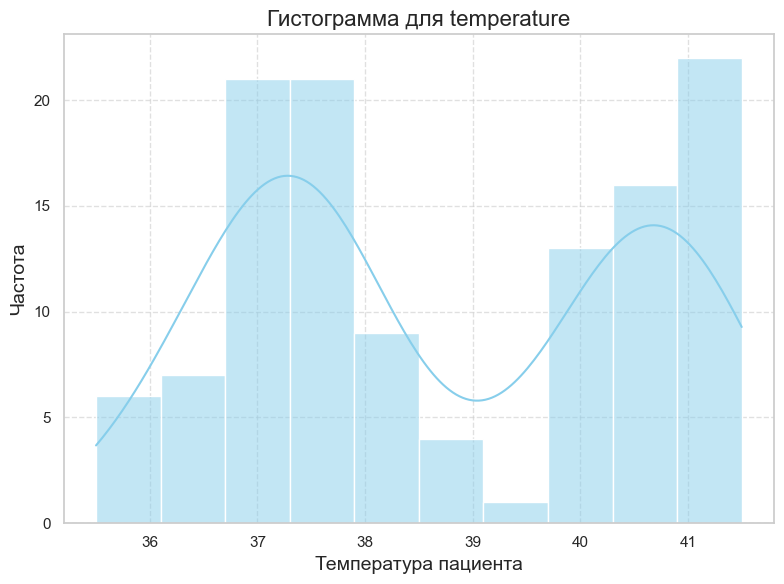

In [10]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.histplot(medical_df.temperature, bins=10, kde=True, color='skyblue')
plt.title('Гистограмма для temperature', fontsize=16)
plt.xlabel("Температура пациента", fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()    

Предположение о мультимодальности подтвердилось, мы имеем 2 пиковых промежутка: температуры между 37 и 38 и температуры выше 41, кроме того подтвердилось предположение о перекосе в сторону высоких температур

Также можно заметить малое количество значений между 39 и 40 градусами, более подробно эту ситуацию можно рассмотреть с помощью диаграммы рассеяния

Построим диаграмму рассеяния для температур пациентов

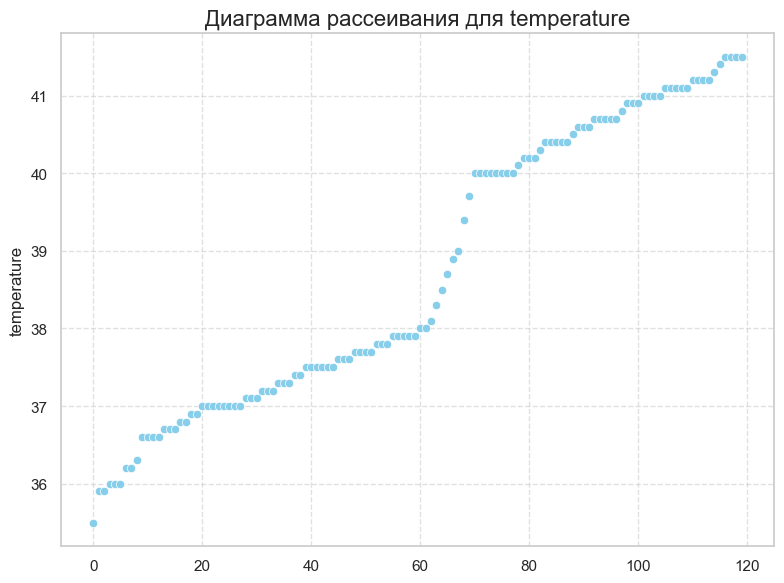

In [11]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.scatterplot(medical_df.temperature, color='skyblue')
plt.title(f'Диаграмма рассеивания для temperature', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Как видно, распределение температур напоминает сигмоиду (логистическая регрессия), также можно заметить, что в промежутке температур между 39 и 40 градусами находится всего лишь 2 наблюдения, однако это не нарушает общую логику зависимости, а значит не может быть выбросом. Подобная ситуация может быть следствием весьма малого количества наблюдений

Еще одним предполагаемым выбросом может быть самая первая точка, однако она тоже не находится слишком далеко от всех наблюдений, чтобы считаться выбросом

Сигмоида является адекватным описанием распределения температур, поскольку существуют максимальное и минимальное значения температуры, при которых человек способен выжить, также имеют место наиболее распространенные значения в контексте пациентов - между 36.6 и 38 (пациенты на начальной стадии заболевания) и между 40 и 41.5 (критически больные пациенты), поэтому график температур адекватен и **не содержит выбросы**.

Для категориальных переменных построим круговые диаграммы

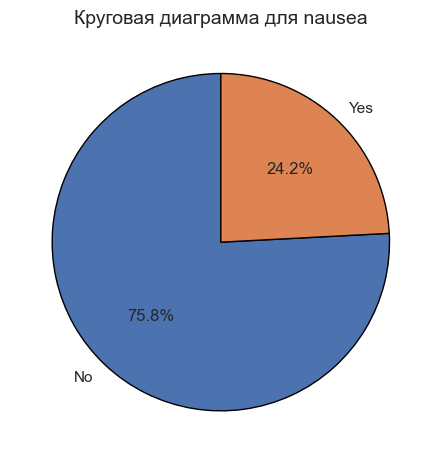

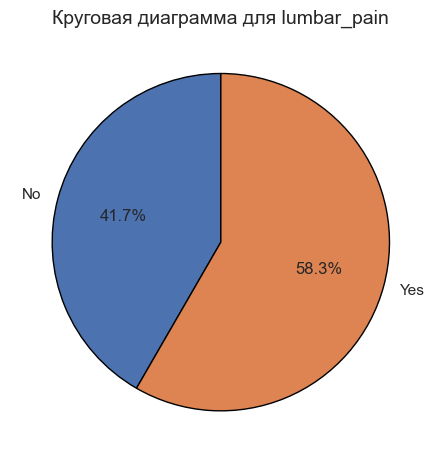

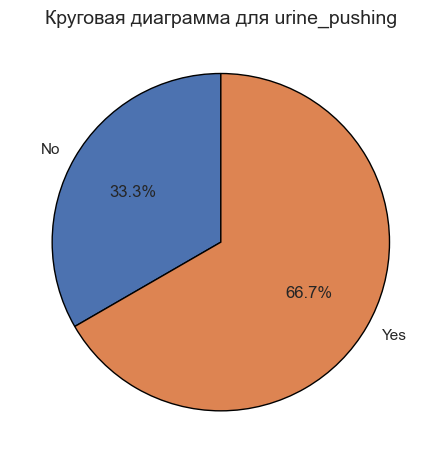

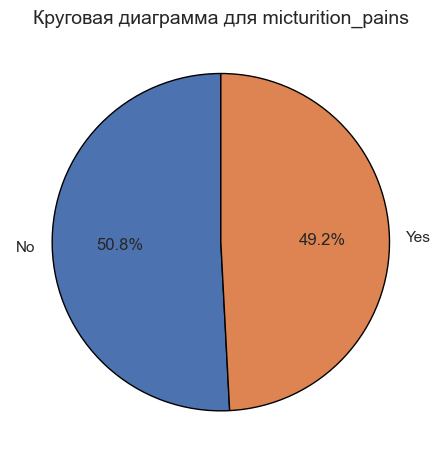

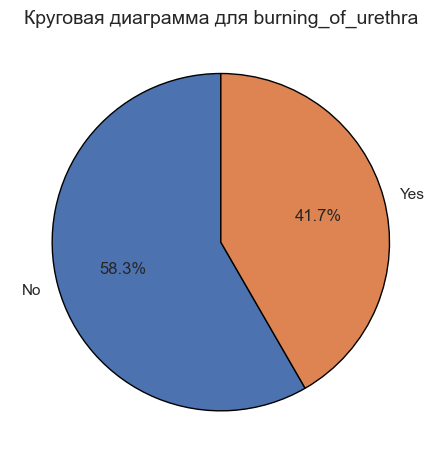

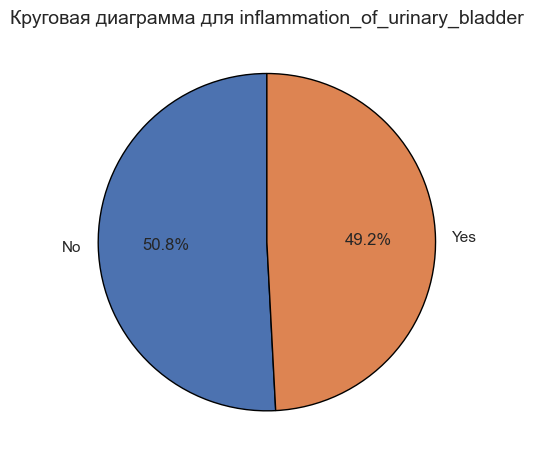

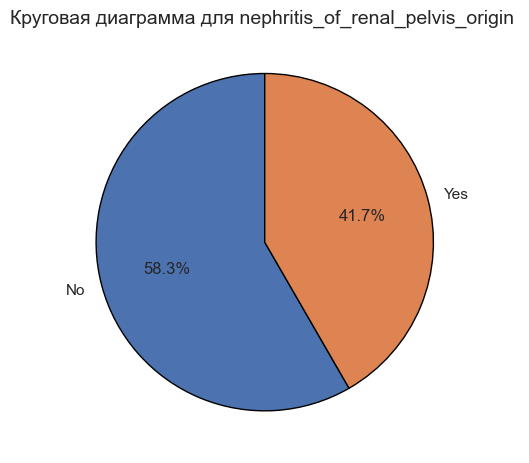

In [12]:
for column in medical_df.select_dtypes(include='int64').columns:
    counts = medical_df[column].value_counts()

    labels = ['No', 'Yes']
    sizes = [counts.get(0, 0), counts.get(1, 0)]

    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    plt.title(f'Круговая диаграмма для {column}', fontsize=14)
    plt.tight_layout()
    plt.show()

Наблюдается сильный дисбаланс в сторону отрицательной метки для показания тошноты и в сторону положительной метки для показания проблем с мочеиспусканием

Дисбаланс для показания тошноты может свидетельствовать о том, что данная метка не является значимой в контексте постановки диагноза для данной ПО, однако это необходимо проверить на основе совместного распределения переменной с другими

Дисбаланс для показания проблем с мочеиспусканием может свидетельствовать о том, что в наборе данных преимущественно были собраны записи о пациентах по отделению урологии, что подтверждает малозначимость показания тошноты

Остальные переменные распределены примерно сбалансированно, что также свидетельствует об **отсутствии** выбросов

Построим для всех переменных диаграмму "Ящик с усами"

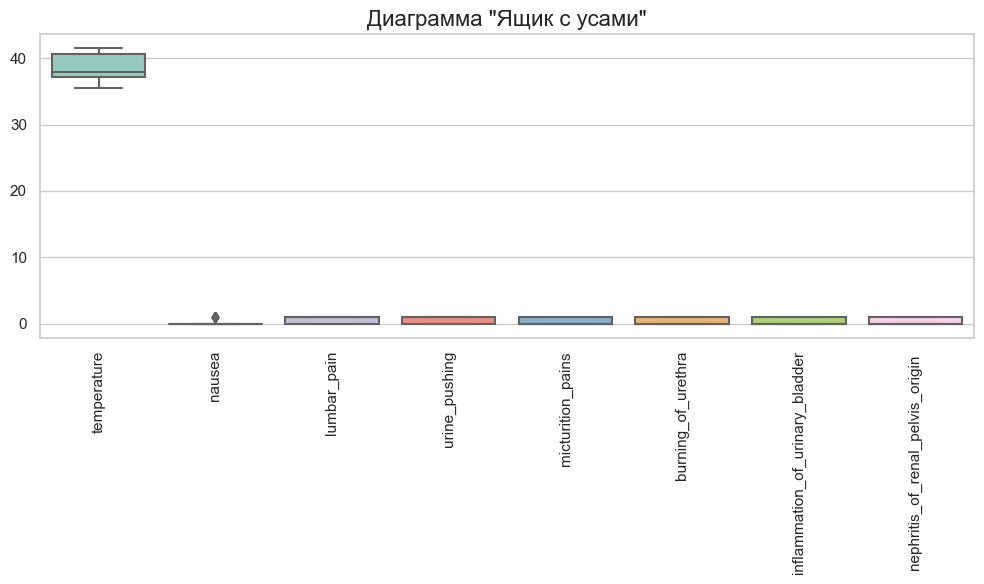

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=medical_df, palette="Set3")
plt.title("Диаграмма \"Ящик с усами\"", fontsize=16)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Видно, что все переменные распределены приблизительно равномерно, исключения - температура и тошнота

Рассмотрим их подробнее

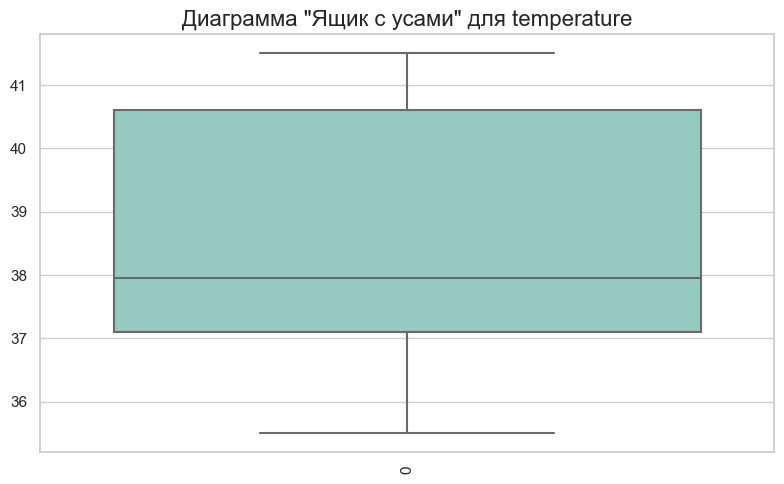

In [14]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=medical_df.temperature, palette="Set3")
plt.title("Диаграмма \"Ящик с усами\" для temperature", fontsize=16)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

По диаграмме можно предположить, что минимальная температура является выбросом, однако она не так сильно смещает распределение, чтобы быть отброшенной.

Кроме того подтверждается перекос в сторону высоких температур

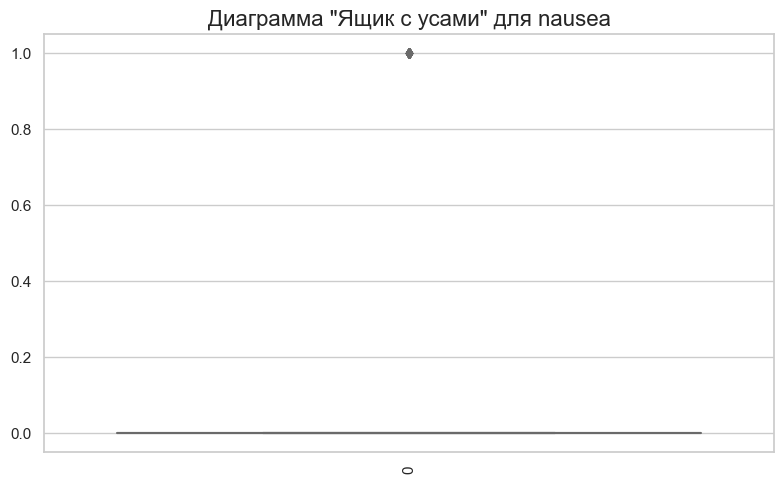

In [15]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=medical_df.nausea, palette="Set3")
plt.title("Диаграмма \"Ящик с усами\" для nausea", fontsize=16)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Здесь мы видим более явный дисбаланс в сторону отрицательных меток, что подтверждает предыдущие выводы

В заключение можно сказать, что явных выбросов в наборе данных **нет**, однако стоит внимательно проанализировать переменные `nausea` и `urine_pushing`, так как у них явно выраженный дисбаланс распределения 

## Выявление коллинеарности

Построим тепловую карту корреляций между переменными

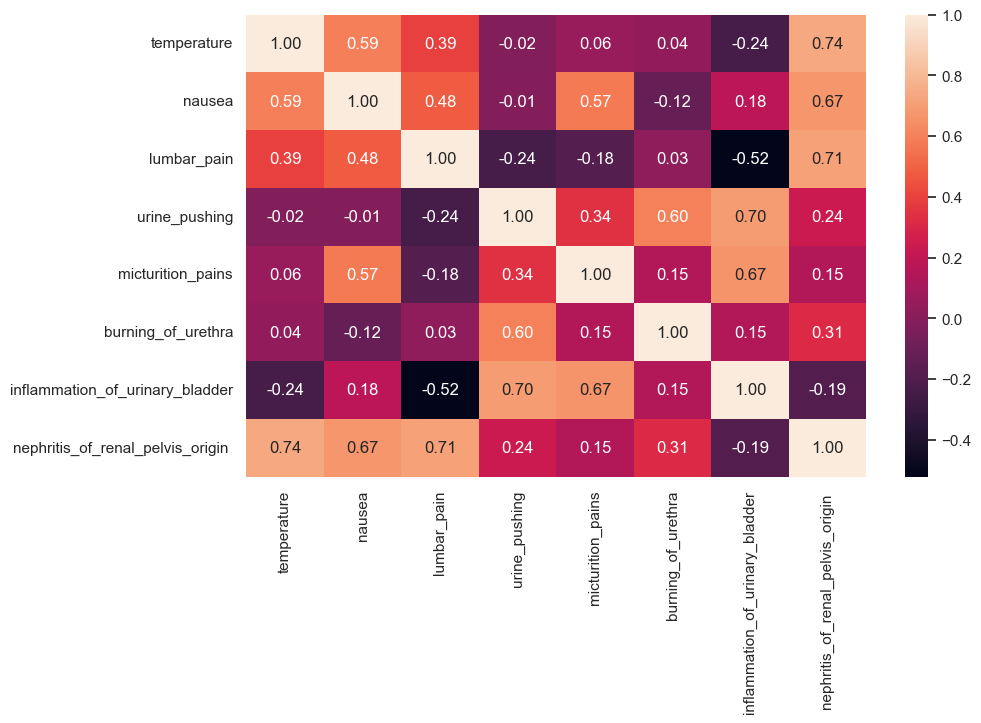

In [16]:
correlations = medical_df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.show()

График показывает, что коэффициенты корреляции в своем большинстве показывают слабую и среднюю корреляцию между переменными, а значит в явном виде мультиколлинеарность отсутствует

Также заметим, что проглядывается средняя связь между тошнотой и рядом других переменных (в том числе и целевой), поэтому данное поле также является значимым

Интересно заметить, что существует сильная связь между температурой и нефритом почечно-лоханочного происхождения, а также ряд других сильных связей целевых переменных с остальными, что может говорить о примерном виде регрессионной предиктивной модели

## Выявление характера связи между переменными

Построим парные диаграммы рассеяния для всех переменных

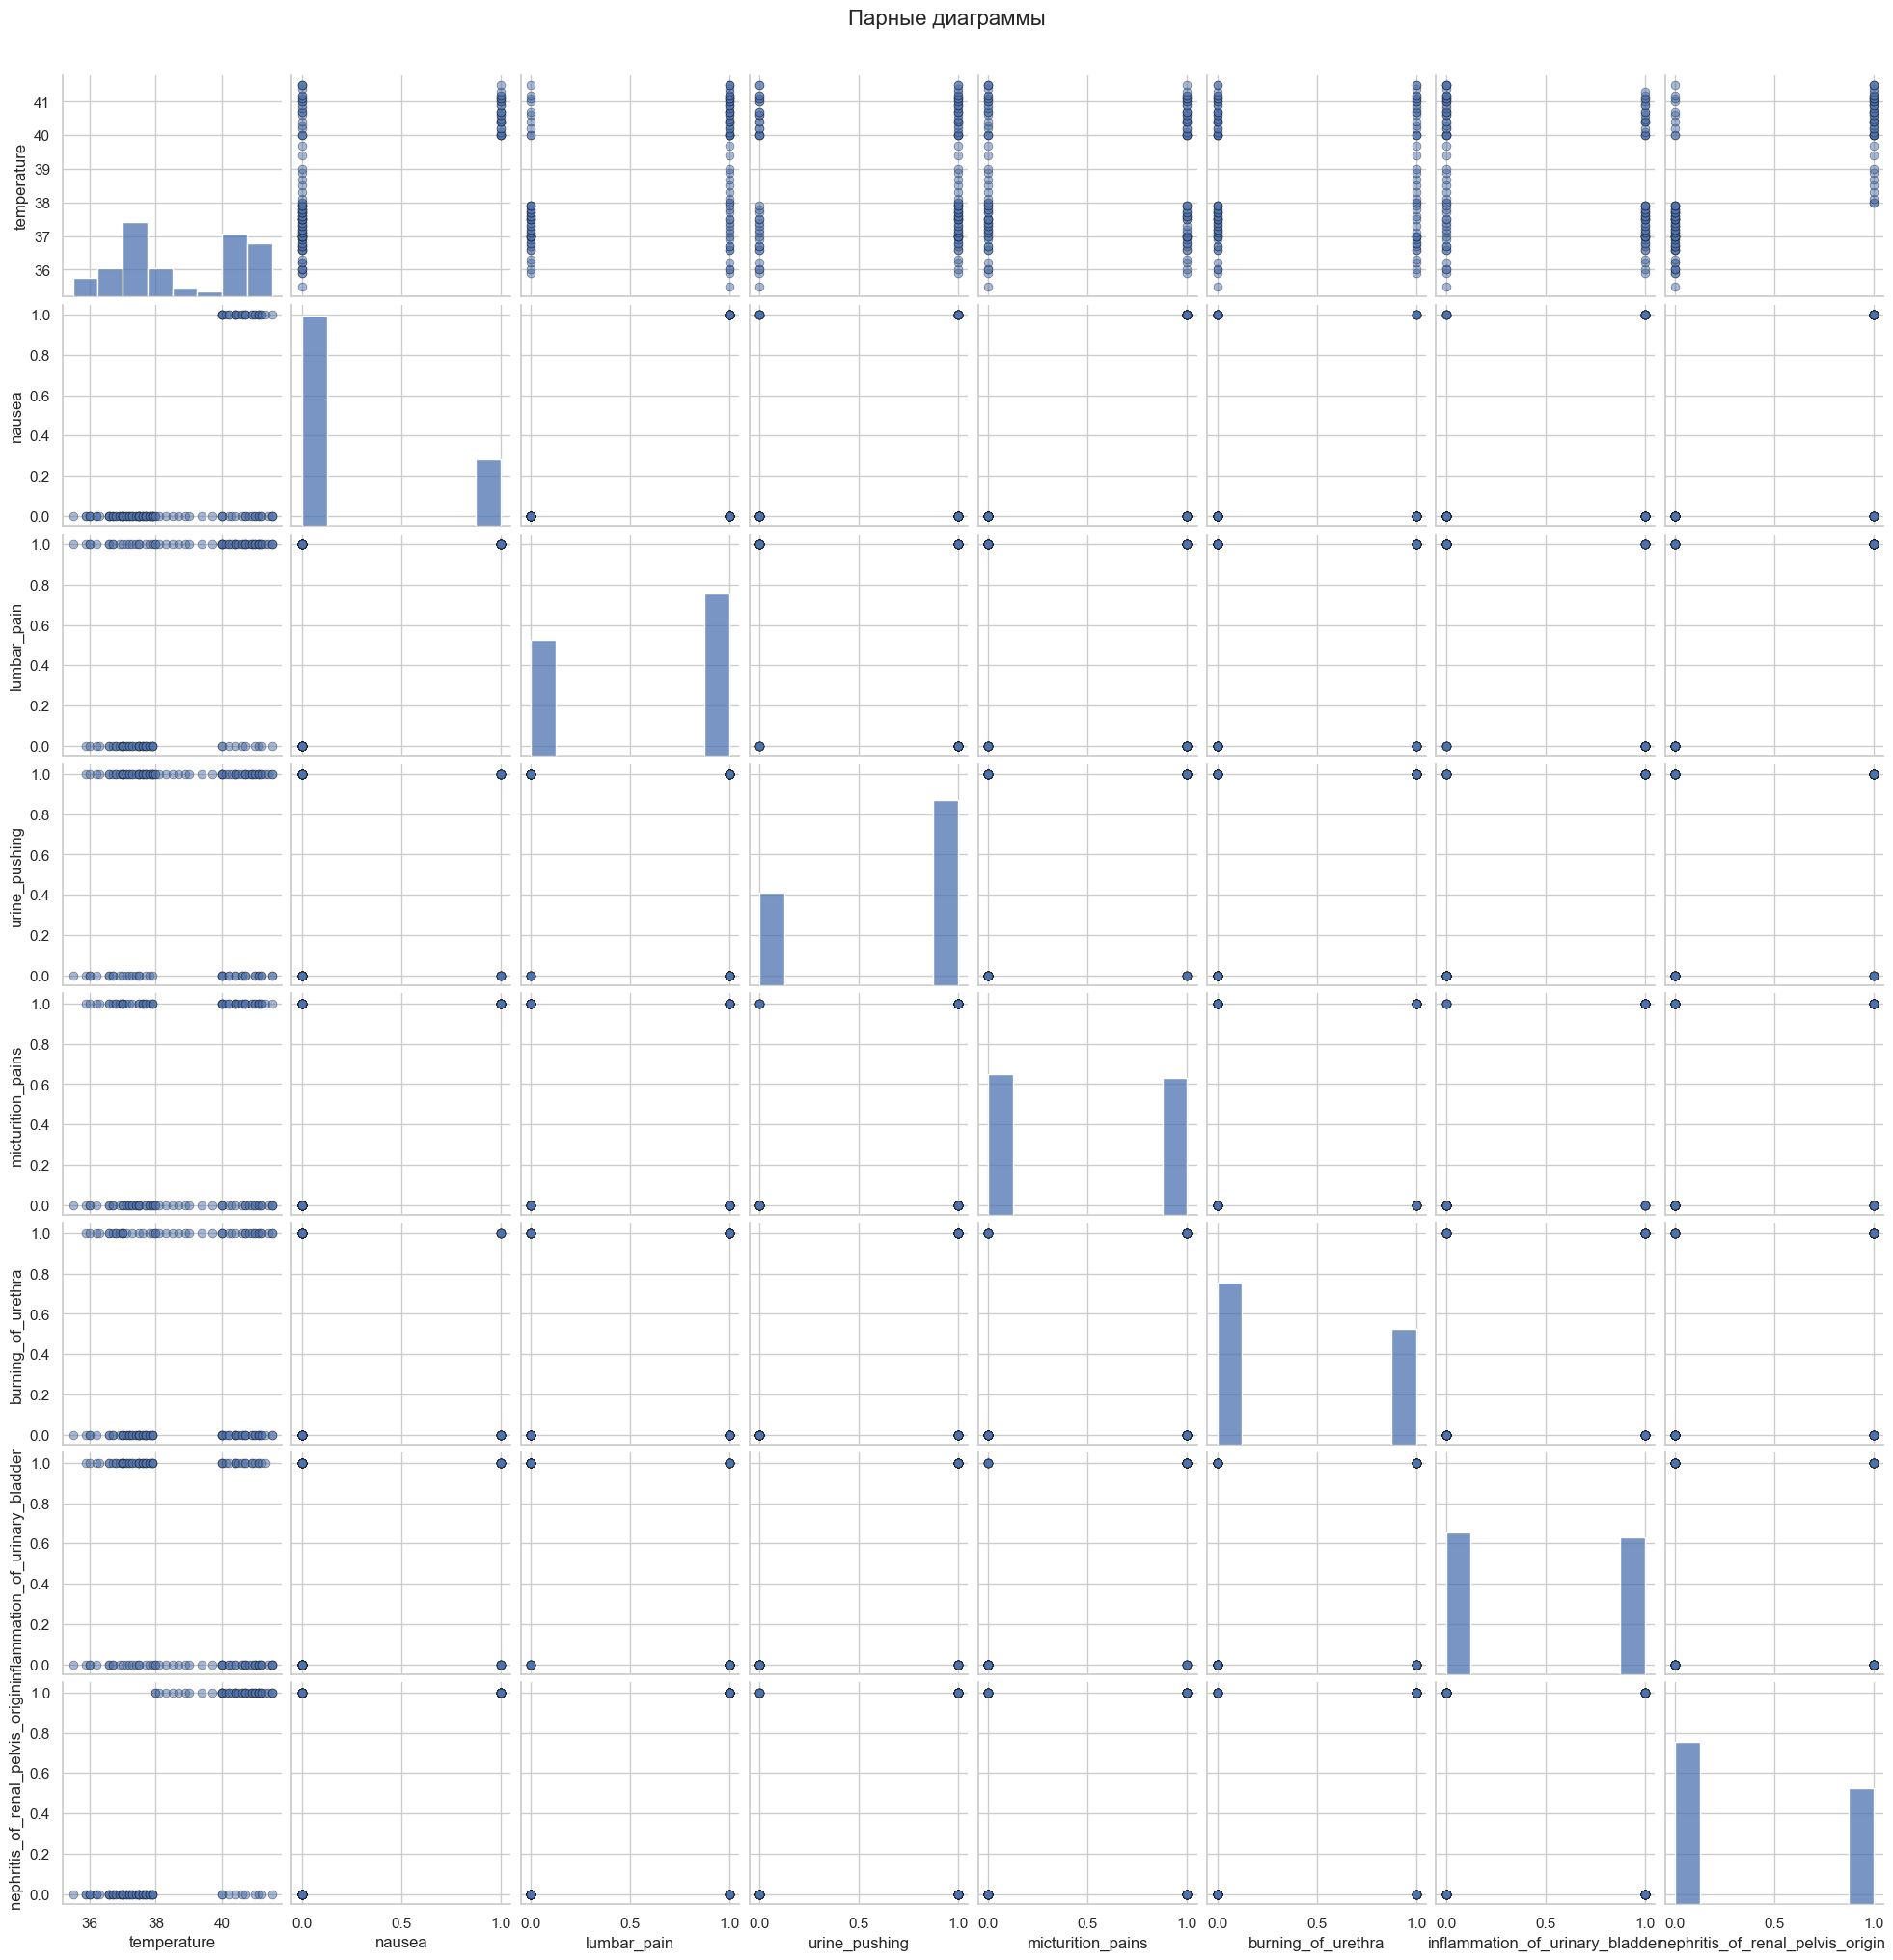

In [17]:
sns.pairplot(medical_df, diag_kind="hist", plot_kws={'alpha':0.5, 's':40, 'edgecolor':'k'})
plt.suptitle("Парные диаграммы", y=1.02, fontsize=16)
plt.show()

Поскольку большинство переменных в датасете - категориальные, подобные диаграммы малоинформативны и нужно искать другой способ визуализации

Чтобы оценить связи между категориальными переменными построим их совместные гистограммы, после чего опишем наиболее интересные взаимосвязи 

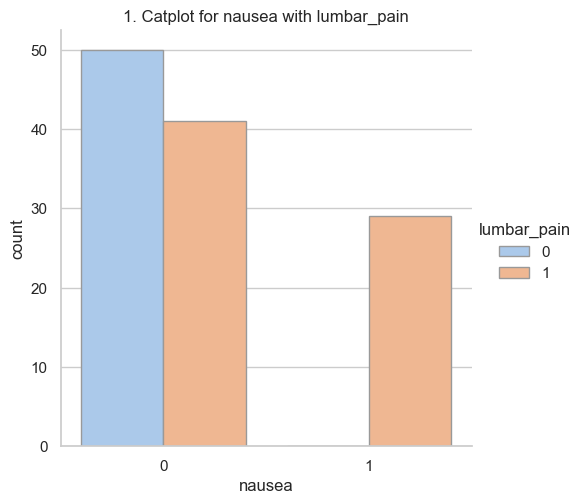

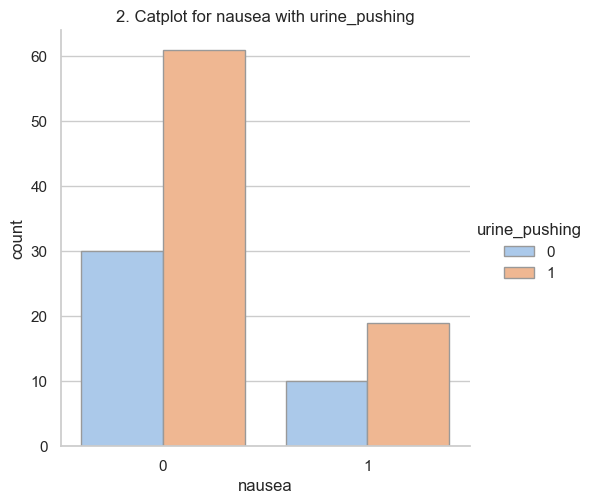

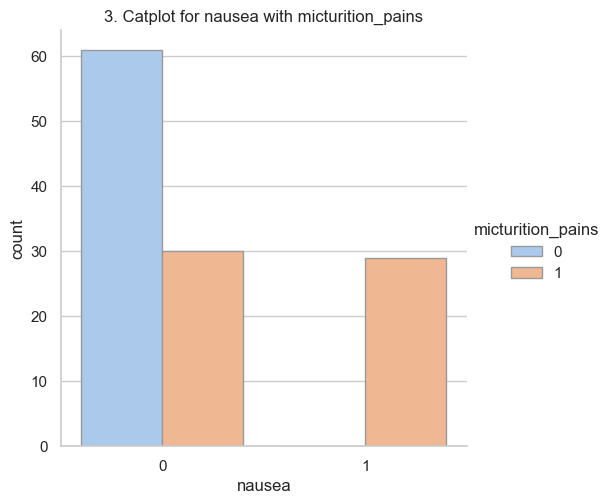

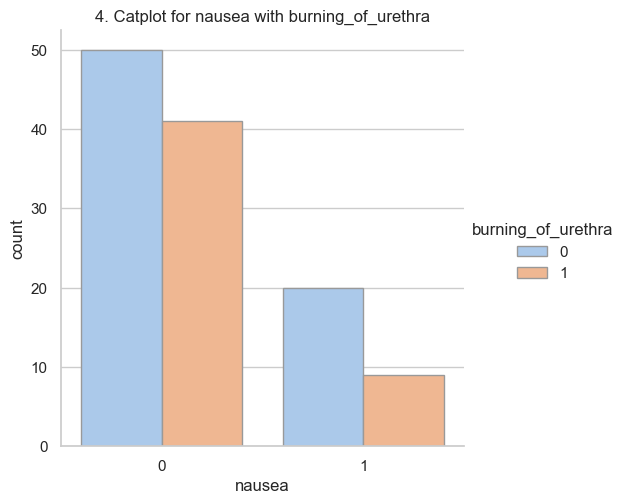

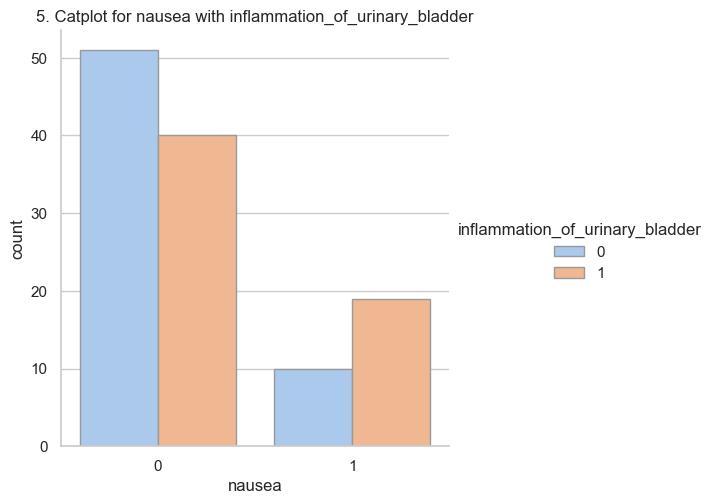

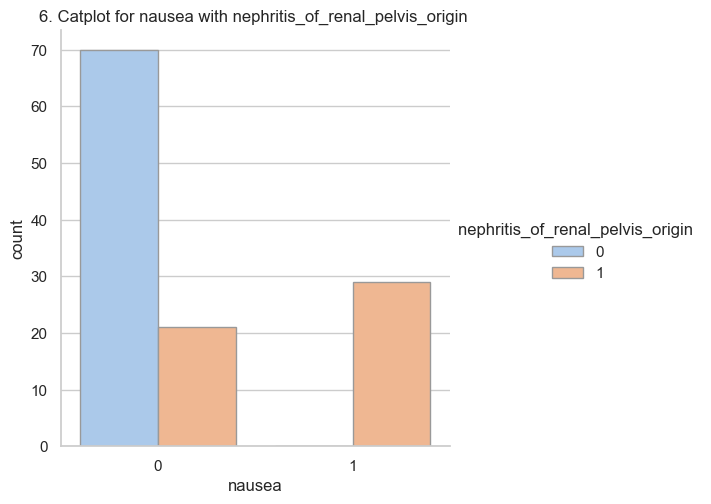

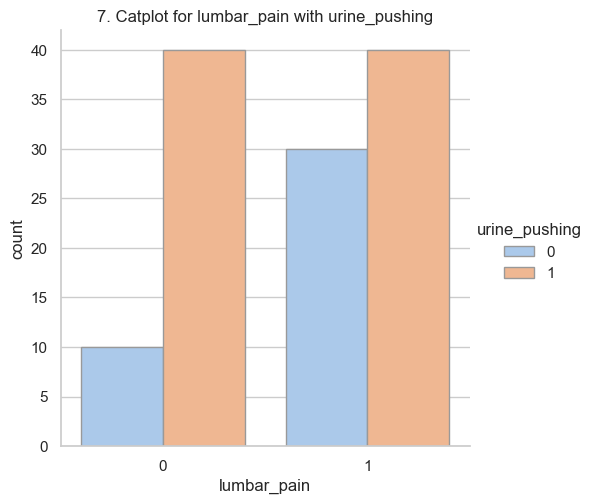

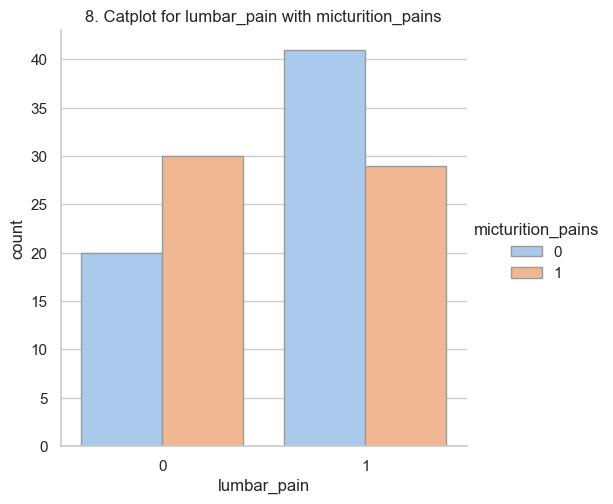

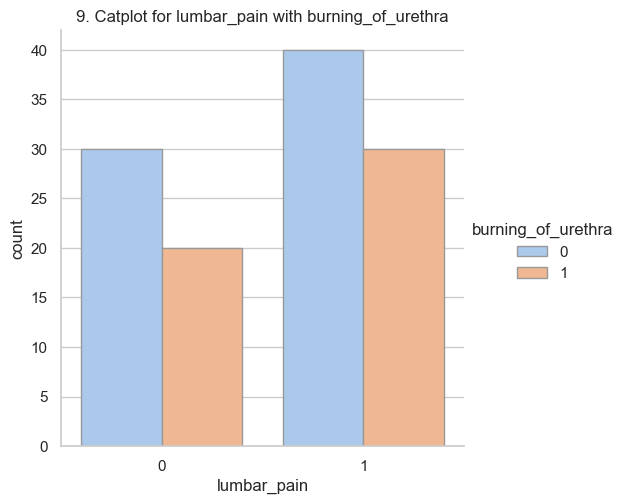

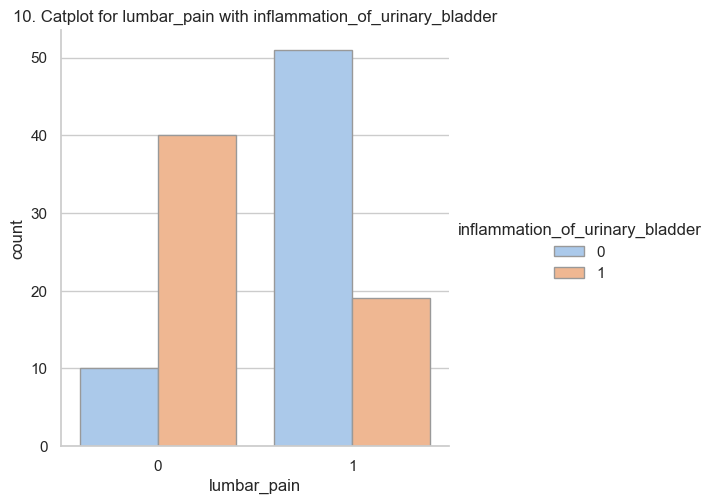

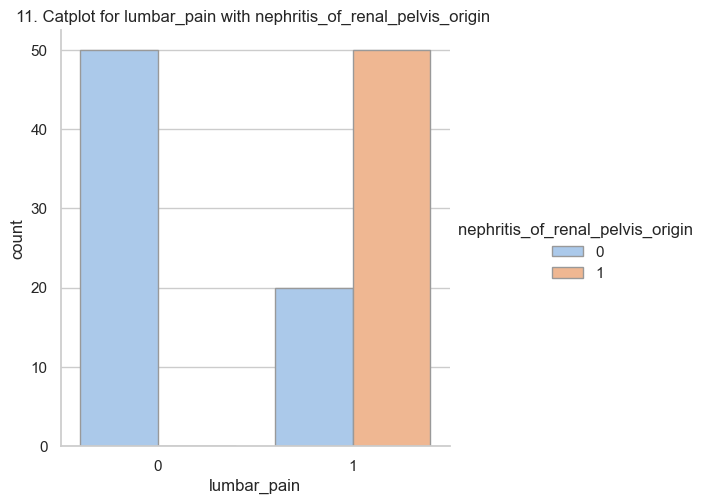

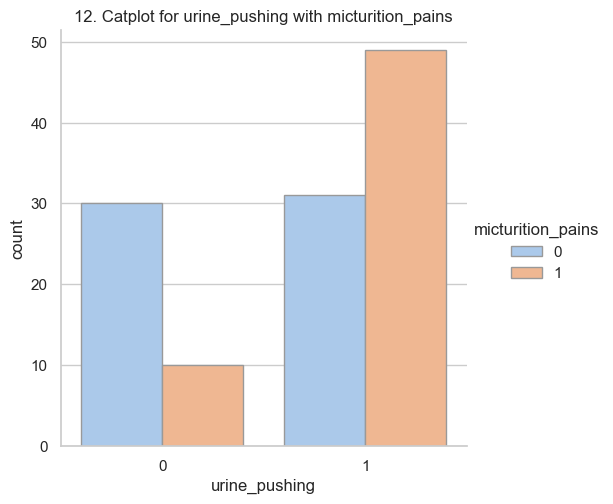

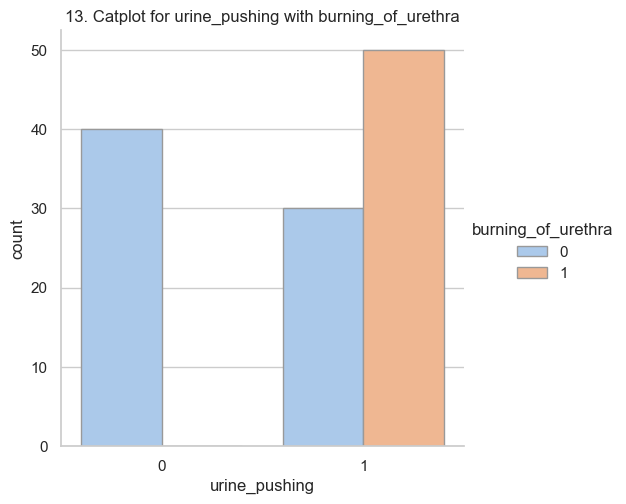

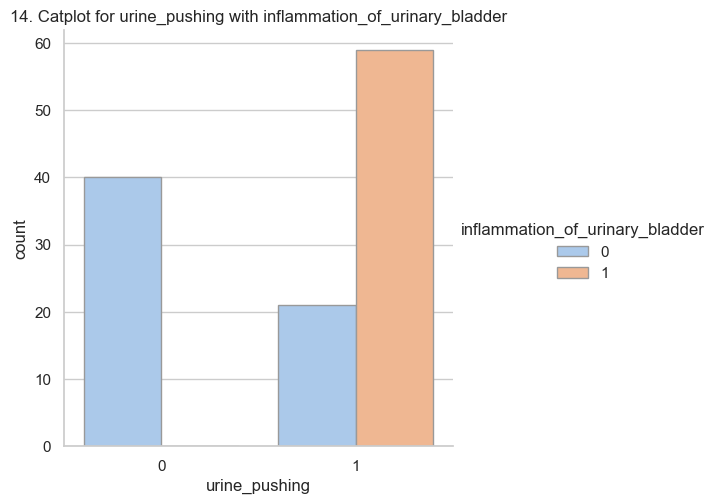

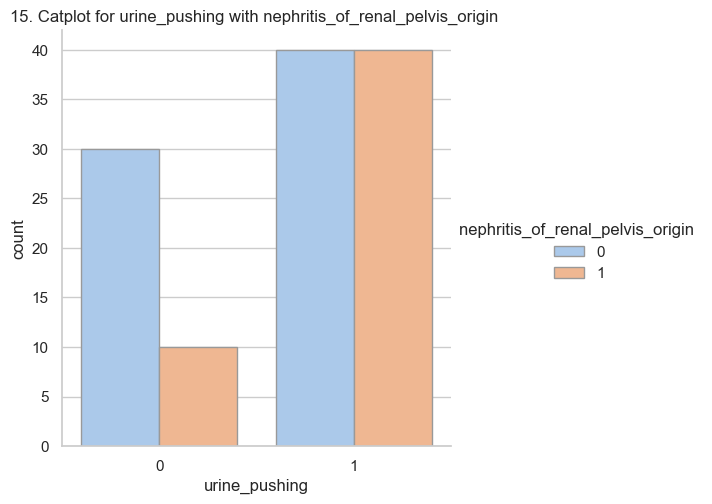

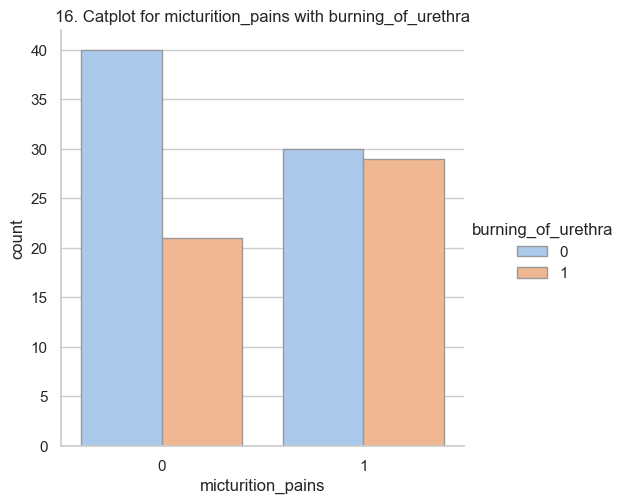

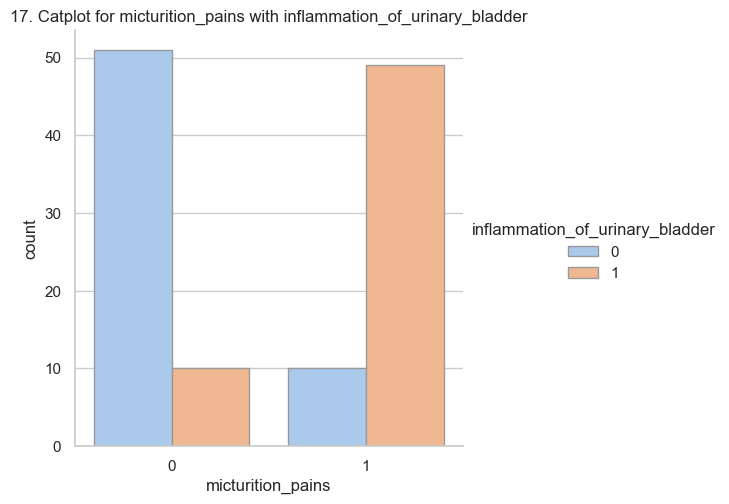

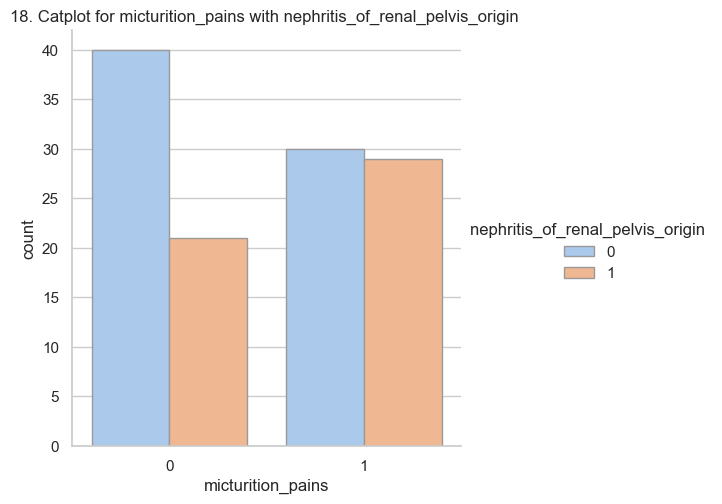

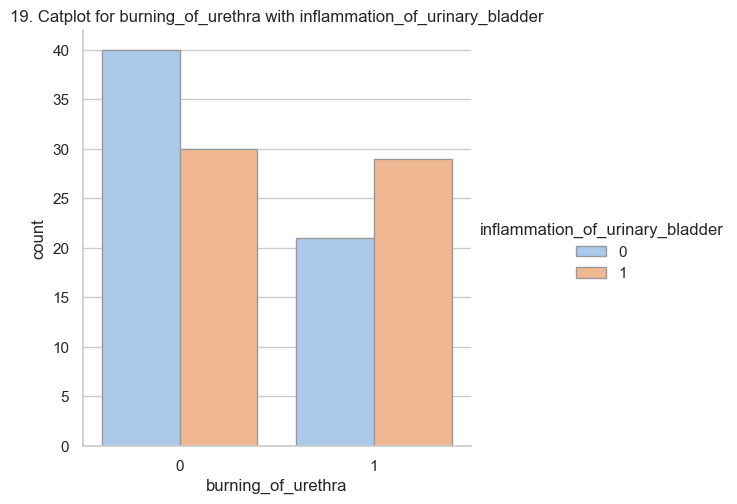

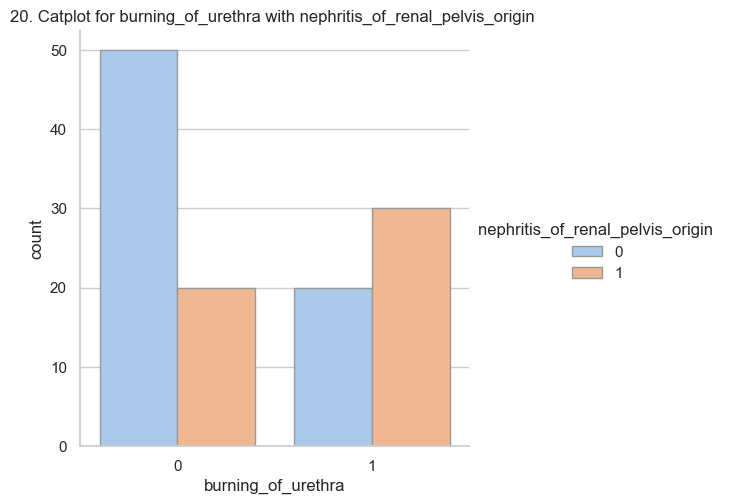

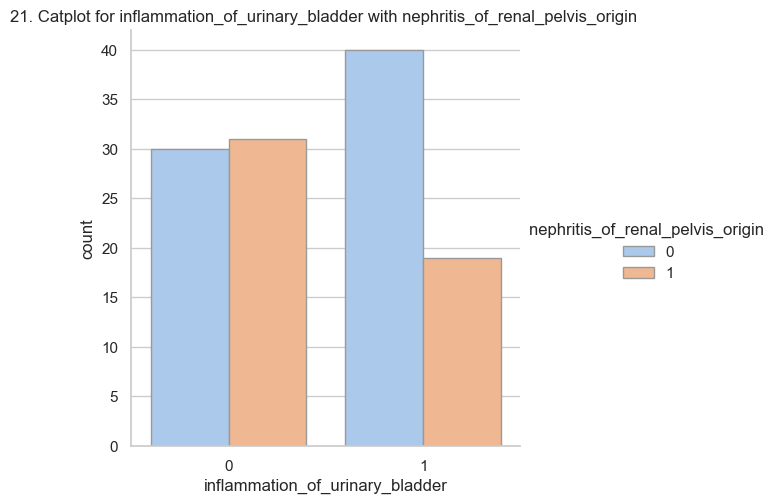

In [18]:
cat_cols = medical_df.select_dtypes(include=["int64", "category"]).columns

chart_number = 0

for i, col1 in enumerate(cat_cols):
    for col2 in cat_cols[i+1:]:
        sns.catplot(x=col1, hue=col2, kind="count", palette="pastel", edgecolor=".6", data=medical_df)
        chart_number += 1
        plt.title(f'{chart_number}. Catplot for {col1} with {col2}')
        plt.show()

На 1-м графике можно увидеть высокую связь тошноты и боли в пояснице - позитивные значения классов полностью встречаются совместно и на 80% совместно встречаются их негативные значения

На 3-м графике заметно, что все пациенты с тошнотой испытывают боль в пояснице, но связь негативных значений невелика, что может говорить о совпадении ввиду низкого числа положительных меток для тошноты

Похожая ситуация наблюдается и на 6-м графике

На 7-м графике видно, что 75% пациентов с болью в пояснице испытывают проблемы с мочеиспусканием, в то время как связь по негативным меткам почти не прослеживается

На 9-м графике можно заметить, что связь между болью в пояснице и жжением в мочеиспускательном канале 75% для положительного класса и 66% для отрицательного, что говорит о взаимной обусловленности симптомов

На 13-м графике видно, что все пациенты, не испытывающие проблем с мочеиспусканием не испытывают жжения в мочеиспускательном канале, в то время как их общее появление наблюдается в 60% случаев, что тоже говорит о высокой связи переменных

Аналогичная связь негативных меток на 14-м графике, однако по распределению положительных можно сказать, что проблемы с мочеиспусканием связаны с воспалением мочевого пузыря меньше, чем с жжением в мочеиспускательном канале

На 15-м графике можно отметить практически полную совстречаемость проблем с мочеиспусканием и нефрита почечно-лоханочного происхождения

Высокая совстречаемость позитивных меток видна и на 16-м графике для боли при мочеиспускании и жжении в мочеиспускательном канале, также в более 50% наблюдений заметна их отрицательная совстречаемость, что говорит о высокой взаимосвязи переменных

Практически аналогичная ситуация и для совстречаемости боли при мочеиспускании и нефрита почечно-лоханочного происхождения (график №18)

На 19-м графике видна совстречаемость жжения в мочеиспускательном канале и воспаления мочевого пузыря примерно на 70% как для позитивного, так и для негативного класса

Подобные наблюдения позволяют предположить, какие переменные наиболее важны для предсказания значений целевых, что может быть полезно при построении и интерпретации регрессионных предиктивных моделей

Однако стоит отметить, что ввиду подавляющего большинства категориальных переменных использование моделей линейной регрессии, хорошо работающих с числовыми признаками, может являться неоптимальным решением

Лучшим решением для построения предиктивной модели может быть либо использование [решающих деревьев](https://ru.wikipedia.org/wiki/Дерево_решений), либо более продвинутых методов-ансамблей, таких как [RandomForest](https://ru.wikipedia.org/wiki/Метод_случайного_леса) и [градиентный бустинг](https://en.wikipedia.org/wiki/Gradient_boosting)